In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import sklearn
import sklearn.model_selection

import pymc as pm
import arviz as az

%matplotlib inline

In [3]:
print(pm.__version__)

4.1.4


### Import Data

In [4]:
data_path = '/content/drive/MyDrive/massbalance-sandbox/docs/emulator_bayes_calib/'

In [5]:
# load specific MB mean for different MB model parameters (i.e. temp_b & melt_f, here done as a test for the Aletsch glacier): 
# choose the one with a fixed pf but variable temp. b and melt factors
pd_spec_mb = pd.read_csv(data_path+'test_mb_RGI60-11.01450_fixed_pf_test.csv', index_col=[0])

# too many values make the notebook slow ... I just removed some parameters again ... 
pd_spec_mb = pd_spec_mb.sort_values(by=['melt_f', 'temp_bias']).iloc[1::3]
pd_spec_mb = pd_spec_mb.sort_values(by=['temp_bias','melt_f']).iloc[::2]

# applied MB model parameters that were used to estimated the real OGGM MB model (partly used for training the emulator)  
X = pd_spec_mb[['temp_bias','melt_f'] ].values 

# modelled specific mean MB (mean over 2000-2020) estimated from the real OGGM MB model (partly used for training the emulator) 
# we later want to match this value (i.e. y) with the geodetic observation 
y = pd_spec_mb['spec_mb_mean'].values

Check on the dataframe

In [6]:
pd_spec_mb[['temp_bias','melt_f', 'spec_mb_mean']]

,temp_bias,melt_f,spec_mb_mean
99,-9.95,15.0,4447.609466
101,-9.95,35.0,4442.662098
103,-9.95,55.0,4437.714730
105,-9.95,75.0,4432.767362
107,-9.95,95.0,4427.819994
...,...,...,...
19791,9.85,915.0,-74043.378533
19793,9.85,935.0,-75693.041314
19795,9.85,955.0,-77342.704096
19797,9.85,975.0,-78992.366877


Following Lily's normalization routine

In [7]:
random_state = 42 
### similar as what David Rounce does in PyGEM:

# normalize parameter data used inside "real" MB model (partly used for training the emulator) 
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# normalize modelled MB data from "real" MB model (partly used for training the emulator) 
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# Split into training and test data (but witout having torch tensors ... )
X_train_pm,X_test_pm,y_train_pm,y_test_pm = sklearn.model_selection.train_test_split(X_norm,y_norm, test_size=0.8)

In [8]:
X_train_pm.shape

(663, 2)

### Visualize the Simulated Data in 3D to ascertain fit shape

This will help us figure out priors to test for GP fit

In [9]:
from mpl_toolkits import mplot3d

In [10]:
%matplotlib inline

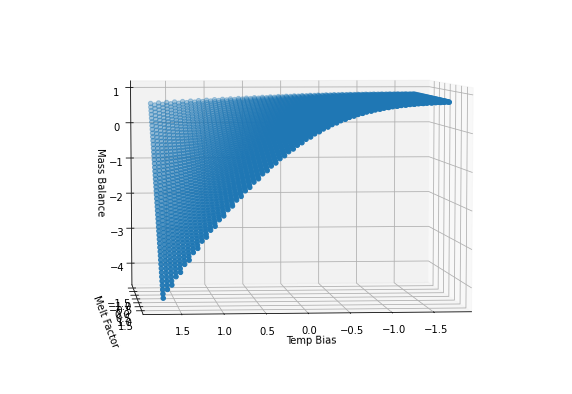

In [11]:
z = y_norm
x = X_norm[:,0]
y = X_norm[:,1]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 

ax.scatter3D(x, y, z)
ax.set_xlabel('Temp Bias')
ax.set_ylabel('Melt Factor')
ax.set_zlabel('Mass Balance')

ax.view_init(5, 85)


There is some degeneracy in the y value for the melt factor and temp bias.

### Geodetic Observations

In [31]:
sigma_geo = [171]
y_geo = [-1210]

### Model Observations on Latent GP trained on Simulation

In [37]:
with pm.Model() as model:
    
    #define the covariance parameters and function
    input_dim = 2 #number of fit variables
    cov = pm.gp.cov.ExpQuad(input_dim, ls=0.1)
    
    #instantiate latent GP
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('latent_gp', X=X_train_pm, 
                 jitter=1e-7)
    
    #assuming marginal GP likelihood is normally distributed
    gp_likelihood = pm.Normal('gp_likelihood', mu=f, observed=y_train_pm)

    #assuming marginal GP likelihood is student-t distributed
    # gp_sigma = pm.HalfNormal('gp_sigma', sigma=2.0)
    # nu = 1 + pm.Gamma('nu', alpha=2, beta=0.1)
    # y_ = pm.StudentT('y', mu=f, lam=1.0/gp_sigma, nu=nu, 
    #                  observed=y_train_pm)

    # #assuming GP has some scatter
    # gp_sigma = pm.HalfCauchy('gp_sigma', beta=3)
    # latent_likelihood = gp.marginal_likelihood('gp_likelihood', 
    #                                            X=X_train_pm, y=y_train_pm, 
    #                                            sigma=gp_sigma)

    latent_trace = pm.sample(500, chains=2, target_accept=0.9)

In [34]:
with model:
    
    #define the "observational" variables for the geodetic best fit
    sigma = pm.Data('sigma', sigma_geo)      
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    Xnew = np.array([t_b, melt_f])[:,None]
    
    #instantiate the conditional fit of GP to new "data"
    gp_mu = gp.conditional('conditional_fit', Xnew=Xnew)
    
    #specify the manifest model
    observed = pm.Data('observed', y_geo)
    log_l = pm.Normal('log_mb', mu=gp_mu, sigma=sigma,
                      observed=observed)

IndexError: ignored